In [1]:
# import sys
# sys.path.append('../')

import torch
from torch.utils.data import DataLoader, Dataset

import numpy as np
import os
from copy import deepcopy
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import cv2

import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.manifold import TSNE
# from umap import UMAP
import pandas as pd
import seaborn as sns

from datasets import PASTIS_Dataset, pad_collate

from models import FCNHead
from torchvision.transforms  import Compose, Resize, CenterCrop, ToTensor, Normalize

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 2
device = torch.device(f"cuda:{device}" if torch.cuda.is_available() else "cpu")

In [4]:
PATH_TO_PASTISR = '/data/common/STIS/PASTIS-R'
img_dt = PASTIS_Dataset(PATH_TO_PASTISR, norm=True, target='semantic', sats=['S2'], resize=128)
img_dl = torch.utils.data.DataLoader(img_dt, batch_size=1, collate_fn=pad_collate, shuffle=False)

Reading patch metadata . . .
Done.
Dataset ready.


In [42]:
n_time_steps = 16
kpt_idx = []
for batch_idx, ((x, dates), y) in enumerate(tqdm(img_dl)):
    B, N, C, H, W = x['S2'].shape
    xs = x['S2'][:, :n_time_steps, :3, :, :].reshape(B*n_time_steps, 3, H, W).to(device)
    brutal_cloud_filter = torch.mean((torch.mean(xs, dim=1) > 0.7).view(-1, H*W).float(), dim=1) < 0.3
    # return the index of the images that are not clouds
    clear_idx = np.where(brutal_cloud_filter.cpu().numpy())[0]
    kpt_idx.append(clear_idx)

  0%|          | 0/2433 [00:00<?, ?it/s]

100%|██████████| 2433/2433 [00:37<00:00, 65.58it/s] 


In [51]:
len(kpt_idx[8])

14

In [61]:
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

Using cache found in /home/haozhesi/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [15]:
fcn = FCNHead(768, 20)

In [6]:
((x, dates), y) = dl.__iter__().__next__()

In [18]:
y.shape

torch.Size([16, 128, 128])

In [32]:
# train cfg
lr = 1e-4
epochs = 10
batch_size = 256
grad_accum = batch_size // 16

critertion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(fcn.parameters(), lr=lr)
resize = Resize((128, 128), antialias=True)

In [33]:
# for all training samples, collect patch level features
dinov2_vitb14.to(device)
dinov2_vitb14.eval()
fcn.to(device)
fcn.train()

pbar = tqdm(dl)

for e in trange(epochs):
    optimizer.zero_grad()
    for batch_idx, ((x, dates), y) in enumerate(pbar):
        B, N, C, H, W = x['S2'].shape
        rand_idx = np.random.randint(0, 38)
        xs = x['S2'].squeeze(1)[:, rand_idx, :3, :, :].to(device)

        with torch.no_grad():
            ret = dinov2_vitb14(xs, is_training=True)
        patch_feat = ret['x_norm_patchtokens'].permute(0, 2, 1).view(B, -1, 32, 32)

        pred = fcn(patch_feat)
        fs_pred = resize(pred)

        loss = critertion(fs_pred, y.to(device)) 
        pbar.set_postfix(loss=loss.item())
        loss /= grad_accum
        loss.backward()

        if batch_idx % grad_accum == 0:
            optimizer.step()
            optimizer.zero_grad()
    break

  0%|          | 0/10 [03:29<?, ?it/s]


KeyboardInterrupt: 

In [23]:
fs_pred.shape, y.shape

(torch.Size([16, 20, 128, 128]), torch.Size([16, 128, 128]))

In [29]:
critertion(fs_pred, y.to(device)).shape

torch.Size([16, 128, 128])

In [3]:
log_dir = f'/data/common/STIS/PASTIS-R/logs/vitb14'
os.makedirs(log_dir, exist_ok=True)
# save all
# torch.save(patch_level_feats, os.path.join(log_dir, 'patch_feat.pt'))
# torch.save(seg_anns, os.path.join(log_dir, 'anns.pt'))
# torch.save(cls_feats, os.path.join(log_dir, 'cls_feat.pt'))

## Fit Seg Head

In [52]:
log_dir = f'/data/common/STIS/PASTIS-R/logs/vitb14'

# load the saved features
patch_level_feats = torch.load(os.path.join(log_dir, 'patch_feat.pt'))
seg_anns = torch.load(os.path.join(log_dir, 'anns.pt'))
# cls_feats = torch.load(os.path.join(log_dir, 'cls_feat.pt'), map_location=device)

In [5]:
patch_level_feats.shape, seg_anns.shape

(torch.Size([2433, 16, 1024, 768]), torch.Size([2433, 128, 128, 1]))

In [53]:
class SimpleDictDataset(Dataset):
    def __init__(self, x, y, kpt_idx=None):
        self.x = x
        self.y = y
        self.N = x.shape[0]
        self.T = x.shape[1]
        self.kpt_idx = kpt_idx
    
    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        if self.kpt_idx is not None:
            time_step = np.random.choice(self.kpt_idx[idx])
        else:
            time_step = np.random.randint(0, self.T)
        return self.x[idx, time_step], self.y[idx]

In [109]:
ds = SimpleDictDataset(patch_level_feats, seg_anns.squeeze(), kpt_idx=kpt_idx)
dl = DataLoader(ds, batch_size=256, shuffle=True)

In [110]:
fcn = FCNHead(768, 20)

In [111]:
# train cfg
lr = 1e-3
epochs = 100

critertion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(fcn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*len(dl), eta_min=1e-6)
resize = Resize((128, 128), antialias=True)

In [112]:
fcn.to(device)
fcn.train()
losses = []
# pbar = tqdm(dl)
for e in trange(epochs):
    for batch_idx, (x, y) in enumerate(dl):
        B, P, D = x.shape
        x = x.permute(0, 2, 1).view(B, D, int(np.sqrt(P)), int(np.sqrt(P))).to(device)
        y = y.to(device)

        pred = fcn(x)
        fs_pred = resize(pred)

        loss = critertion(fs_pred, y.long()) 
        losses.append(loss.item())
        # pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:54<00:00,  2.34s/it]


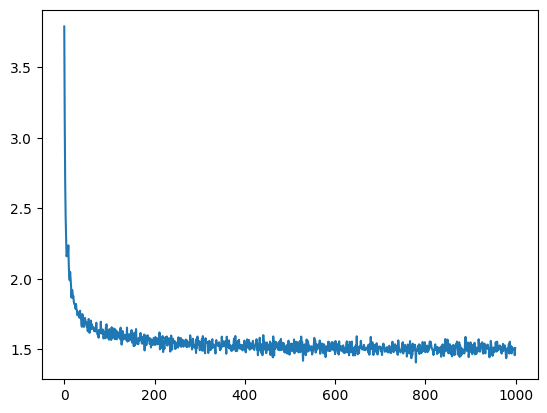

In [113]:
plt.plot(losses)

In [114]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

/tmp/ipykernel_2141819/4237036781.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap('tab20')


## Val

In [115]:
PATH_TO_PASTISR = '/data/common/STIS/PASTIS-R'
img_dt = PASTIS_Dataset(PATH_TO_PASTISR, norm=True, target='semantic', sats=['S2'], resize=448, mono_date='40')
img_dl = torch.utils.data.DataLoader(img_dt, batch_size=1, collate_fn=pad_collate, shuffle=False)

Reading patch metadata . . .
Done.
Dataset ready.


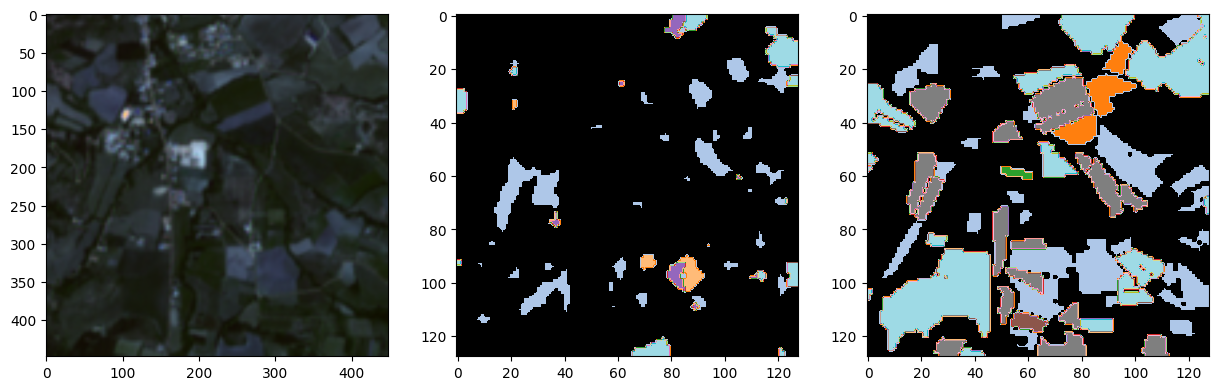

In [118]:
sample_idx = 800
(x, date), y = img_dt[sample_idx]
x = x['S2'][:, :3, :, :].to(device)
dinov2_vitb14.eval().to(device)
fcn.eval().to(device)
with torch.no_grad():
    ret = dinov2_vitb14(x, is_training=True)
    patch_feat = ret['x_norm_patchtokens'].permute(0, 2, 1).view(1, -1, 32, 32)
    pred = fcn(patch_feat)
    fs_pred = resize(pred)
    # arg over dim 1
    fs_pred = torch.argmax(fs_pred, dim=1).squeeze().cpu().numpy()

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
vis = x[0].permute(1, 2, 0).cpu().numpy()
vis = (vis - vis.min()) / (vis.max() - vis.min())
plt.imshow(vis)
plt.subplot(1, 3, 2)
plt.imshow(fs_pred, cmap=cmap, vmin=0, vmax=20)
plt.subplot(1, 3, 3)
plt.imshow(y.squeeze().cpu().numpy(), cmap=cmap, vmin=0, vmax=20)